## Imports

In [2]:
import os

%matplotlib inline
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import tests_hw5
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

<br><br>

## Explaining the problem

In this mini project, we will be working on a classification problem of predicting whether a credit card client will default or not. 
For this problem, we will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; the target column is labeled "default.payment.next.month" in the data.

In [3]:
cc_data = pd.read_csv("data/UCI_Credit_Card.csv")
cc_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0




<br><br>

## Data splitting

In [4]:
train_df, test_df = train_test_split(cc_data, test_size=0.3, random_state=123)
train_df.shape

(21000, 25)



<br><br>

In [5]:
train_df['EDUCATION'].value_counts()

2    9815
1    7433
3    3416
5     210
4      81
6      35
0      10
Name: EDUCATION, dtype: int64

## EDA (exploratory data analysis)

We are going to be focusing on bill amounts, pay anounts and pay status for EDA in order to avoid our own bias associated with gender, education and marriage status. We are also going to plot bill amount - pay amount as we hypotehsise that it could be one of the key factors in determining whether a client defaults or not

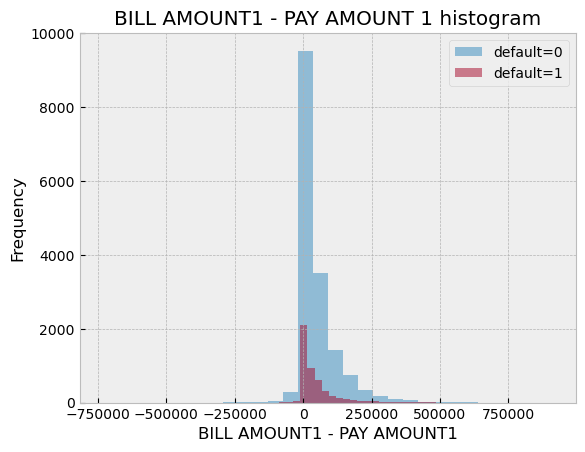

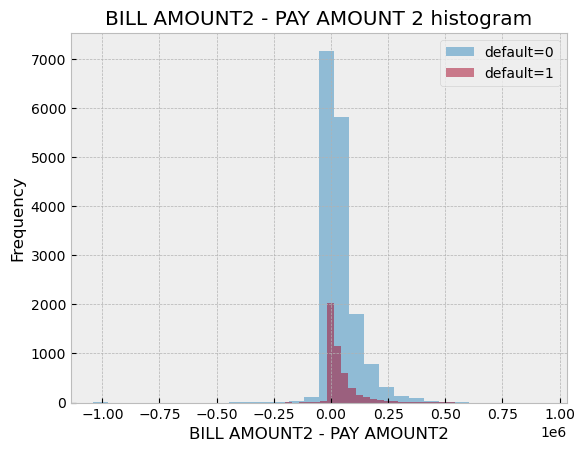

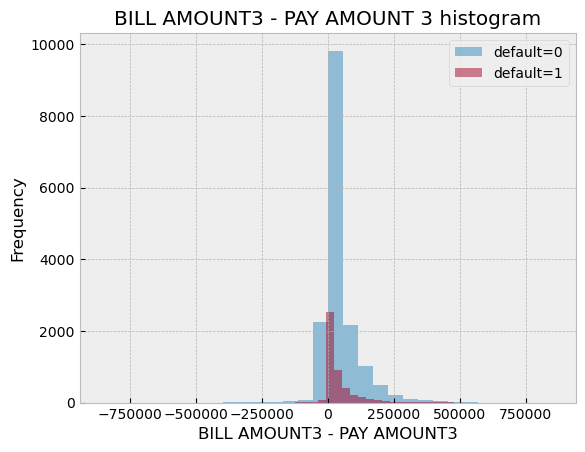

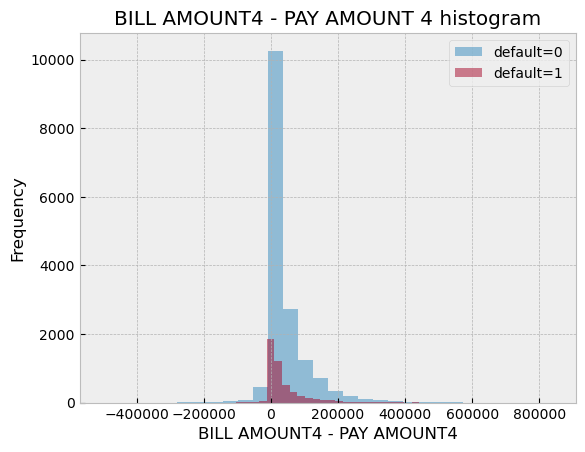

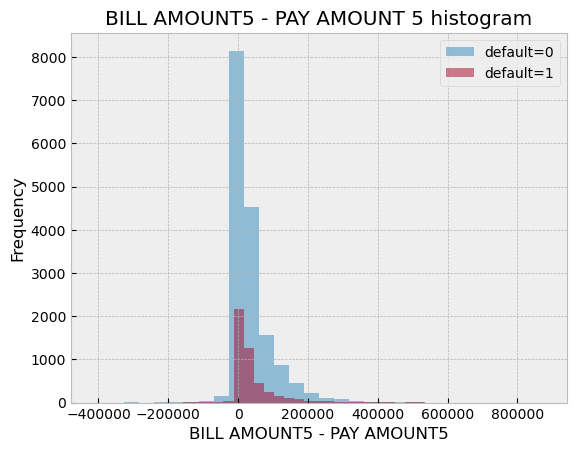

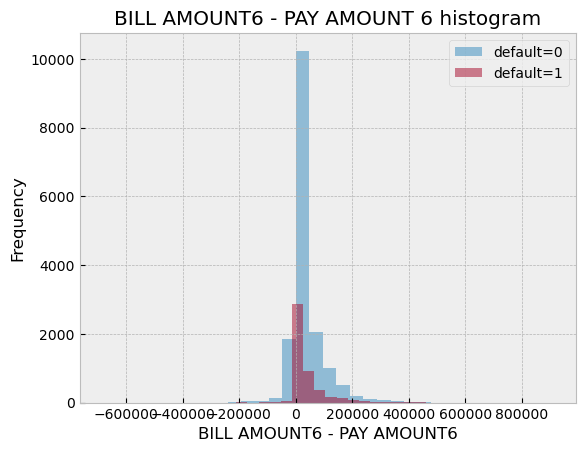

In [6]:
for i in range(1,7):
    plt.style.use("bmh")
    diff_amt1 = train_df["BILL_AMT"+str(i)] - train_df["PAY_AMT"+str(i)]
    plt.hist(diff_amt1[train_df["default.payment.next.month"] != 1], bins=30, alpha=0.5, label='default=0')
    plt.hist(diff_amt1[train_df["default.payment.next.month"] == 1], bins=30, alpha=0.5, label='default=1')
    plt.legend(loc='upper right')
    plt.title("BILL AMOUNT"+str(i)+" - PAY AMOUNT "+str(i)+" histogram")
    plt.xlabel("BILL AMOUNT"+str(i)+" - PAY AMOUNT"+str(i))
    plt.ylabel("Frequency")
    plt.show()

the above plots are used to see the difference between bill amount and pay amount at the end of each month and see if there is a significant difference between clients who default vs who don't. 

Based on the above plots, there does not seem to be significant correlation. 

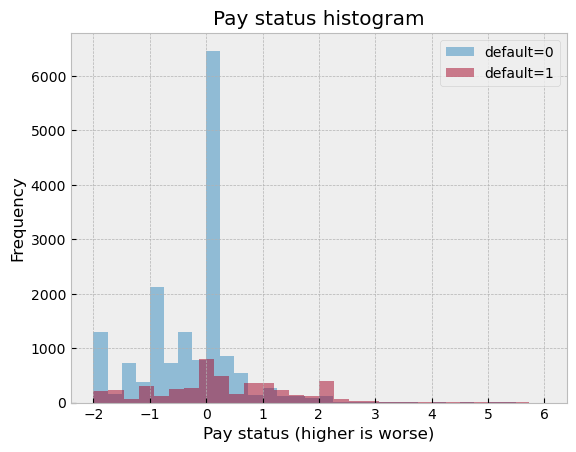

In [7]:
columns_to_average = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
average_df = sum(train_df[col] for col in columns_to_average) / len(columns_to_average)
plt.style.use("bmh")
plt.hist(average_df[train_df["default.payment.next.month"] != 1], bins=30, alpha=0.5, label='default=0')
plt.hist(average_df[train_df["default.payment.next.month"] == 1], bins=30, alpha=0.5, label='default=1')
plt.legend(loc='upper right')
plt.title("Pay status histogram")
plt.xlabel("Pay status (higher is worse)")
plt.ylabel("Frequency")
plt.show()

the above plots are used to see the average pay status for each client. Pay status is ordinally encoded with higher value having a worse status.  

Based on the above plots, clients who default seem to have a higher average pay status (worse) then those who don't. 

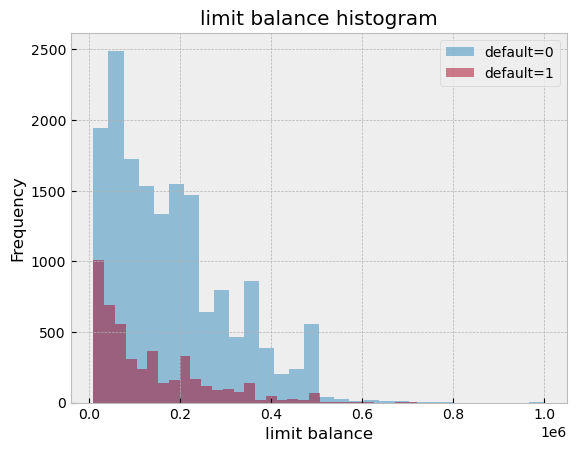

In [8]:
plt.style.use("bmh")
plt.hist(train_df["LIMIT_BAL"][train_df["default.payment.next.month"] != 1], bins=30, alpha=0.5, label='default=0')
plt.hist(train_df["LIMIT_BAL"][train_df["default.payment.next.month"] == 1], bins=30, alpha=0.5, label='default=1')
plt.legend(loc='upper right')
plt.title("limit balance histogram")
plt.xlabel("limit balance")
plt.ylabel("Frequency")
plt.show()

the above plots are used to see the limit balance of each client and see if there is a significant difference between clients who default vs who don't. 

Based on the above plots, there does not seem to be significant correlation. 

In [9]:
summary_stat_1 = train_df.groupby("default.payment.next.month")["LIMIT_BAL"].mean()
summary_stat_1

default.payment.next.month
0    178297.940167
1    131633.464164
Name: LIMIT_BAL, dtype: float64

In [10]:
pays = ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
pays_dict = {}
for i in pays:
    pays_dict[i] = (train_df.groupby("default.payment.next.month")[i].mean())
pd.DataFrame(pays_dict)

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
default.payment.next.month,,,,,,
0,-0.210704,-0.306891,-0.325834,-0.362862,-0.391675,-0.414971
1,0.664036,0.453712,0.364974,0.253626,0.178328,0.122014


Here we are looking at summary statistics for pay status of the clients who default vs who don't in different months. 

### Summary

Based on the summary statistics and the plots above, it seems that the main difference between the clients who default is that they are paying after due date. Based on the pay status plot, the later due date is, the more likely you are to default. 

The balance amount and pay amount (for any of the months) does not seem to have a significant correlation.

## Pick metrics

For this situation, I believe recall is equally as important as precision. However, using F1-Score will provide a good balance.



<br><br>

## Preprocessing and transformations

In [11]:
train_df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 16395 to 19966
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          21000 non-null  int64  
 1   LIMIT_BAL                   21000 non-null  float64
 2   SEX                         21000 non-null  int64  
 3   EDUCATION                   21000 non-null  int64  
 4   MARRIAGE                    21000 non-null  int64  
 5   AGE                         21000 non-null  int64  
 6   PAY_0                       21000 non-null  int64  
 7   PAY_2                       21000 non-null  int64  
 8   PAY_3                       21000 non-null  int64  
 9   PAY_4                       21000 non-null  int64  
 10  PAY_5                       21000 non-null  int64  
 11  PAY_6                       21000 non-null  int64  
 12  BILL_AMT1                   21000 non-null  float64
 13  BILL_AMT2                  

In [13]:
train_df = train_df.assign(EDUCATION = train_df["EDUCATION"].replace(5,4).replace(6,4).replace(0,4))
test_df = test_df.assign(EDUCATION = test_df["EDUCATION"].replace(5,4).replace(6,4).replace(0,4))

numeric_cols = ['LIMIT_BAL', 'AGE', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 
                'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 
                'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
onehot_cols = ['MARRIAGE']
drop_cols = ["SEX"]

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_cols),
    (OneHotEncoder(), onehot_cols),
    ("drop", drop_cols)
)

### Explaination
There does not seem to be any missing values so we do not have to impute any of the numerical or ordinally encoded columns (example: ```EDUCATION```). 

We changed the following education fields: 4:"others", 5:"unknown", 6:"unknown" to just 4:"others. they were already ordinally encoded in the data set so, we did not have to encode it ourselves (based on the kaggle site).

We also did not change the ordinally encoding for the PAY_n columns where n is from 0 to 6 because it seems to have already been ordinally encoded by kaggle based on how late the payment is. 

The marriage was ordinally encoded which did not make sense so, we turned transformed it with one hot encoding for each of the marriage status. 

"We have standardised all the numeric columns such that there is no dominating column.

We are also dropping the column Sex to avoid biases in the model due to it



<br><br>

## Baseline models

In [14]:
X_train = train_df.iloc[:,1:24]
y_train = train_df["default.payment.next.month"]
X_test = test_df.iloc[:,1:24]
y_test = test_df["default.payment.next.month"]
dummy = make_pipeline(preprocessor, DummyClassifier())
dummy.fit(X_train, y_train)
dummy.predict(X_train)

array([0, 0, 0, ..., 0, 0, 0])

<!-- END QUESTION -->



In [15]:
cross_val_score(dummy, X_train, y_train)

array([0.77690476, 0.77690476, 0.77666667, 0.77666667, 0.77666667])

<br><br>

## Attempting linear models

In [16]:
C_values = [0.001, 0.1, 1, 10, 100,1000]

lr_c_scores = {}

for i in C_values:
    lr = make_pipeline(preprocessor, LogisticRegression(C = i, max_iter=1000000)) # max iteration increased for model to converge
    lr.fit(X_train, y_train)
    cv_scores = cross_val_score(lr,X_train,y_train, cv = 5)
    lr_c_scores[i] = [cv_scores.mean(), np.std(cv_scores), lr.score(X_train, y_train)]

lr_c_scores

{0.001: [0.8004285714285715, 0.0031637114746425033, 0.8015238095238095],
 0.1: [0.8097142857142856, 0.002886358563941306, 0.8106190476190476],
 1: [0.810142857142857, 0.002645322745205914, 0.8108095238095238],
 10: [0.8101904761904761, 0.0026700658607383037, 0.8108571428571428],
 100: [0.8102380952380951, 0.002710523708715722, 0.8108571428571428],
 1000: [0.8101904761904761, 0.0026700658607383037, 0.8108571428571428]}

In [17]:
lr_c_scores = pd.DataFrame.from_dict(lr_c_scores, orient = "index", columns  = ["cv_mean", "cv_sd", "train"])
lr_c_scores

,cv_mean,cv_sd,train
0.001,0.800429,0.003164,0.801524
0.100,0.809714,0.002886,0.810619
1.000,0.810143,0.002645,0.810810
10.000,0.810190,0.002670,0.810857
100.000,0.810238,0.002711,0.810857
1000.000,0.810190,0.002670,0.810857


### Summarize results

Since the test and train scores is approximately similar for all values of C, the models seems to be underfitting for lower C values with lower cv mean and train scores and ovefitting for C values above 1000 as the cv mean score has decreased but the training score is still high so, we will use a model that yielded the highest CV mean score: ```C=100```



<br><br>

## Attempting non-linear models

In [18]:
from sklearn.neighbors import KNeighborsClassifier

knn = make_pipeline(preprocessor, KNeighborsClassifier())
knn.fit(X_train, y_train)
pd.DataFrame(cross_validate(knn,X_train,y_train, return_train_score = True))

,fit_time,score_time,test_score,train_score
0,0.010191,0.135009,0.784524,0.842083
1,0.006957,0.088169,0.790952,0.842857
2,0.007558,0.092625,0.796905,0.842976
3,0.007362,0.086931,0.799286,0.841131
4,0.006846,0.085356,0.792381,0.846071


In [19]:
from sklearn.svm import SVC

svm = make_pipeline(preprocessor, SVC(kernel = "rbf"))
svm.fit(X_train, y_train)
pd.DataFrame(cross_validate(svm,X_train,y_train, return_train_score = True))

,fit_time,score_time,test_score,train_score
0,6.098256,1.507148,0.814286,0.826488
1,6.171143,1.539248,0.815714,0.825595
2,6.189978,1.544291,0.823095,0.823750
3,6.274889,1.529227,0.822619,0.823333
4,6.188432,1.536688,0.817857,0.825655


In [20]:
rf = make_pipeline(preprocessor, RandomForestClassifier(random_state = 123, n_jobs = -1))
rf.fit(X_train, y_train)
pd.DataFrame(cross_validate(rf,X_train,y_train, return_train_score = True))

,fit_time,score_time,test_score,train_score
0,2.824726,0.033115,0.805952,0.998988
1,0.719002,0.031025,0.815238,0.999107
2,0.700334,0.030028,0.820952,0.999048
3,0.707566,0.031033,0.821905,0.998750
4,0.719389,0.030508,0.813095,0.999226


The knn model seems to be overfitting more than the SVC (RBF) model as the difference between the cv scores and the train scores is higher in comparison to SVC, however, it has the fastest fit time.

The SVC RBF seems to the overfitting the least out of all three of the model and is also providing the best cv scores in comparison to the other models (does not seem to be underfitting) however, it has the longest fit time.

The RandomForestClassiefier seems to be overfitting too as it has very high train score ~ 1 but not that high cv score. It's validation scores seem to be above knn model's but still relatively similar to the SVC model, the fit time for this model is also right in between the two other models.



<br><br>

## Feature selection

Here we are using a logistic regression to perform forward selection however, the forward selection algorithm is not working well the pipeline and thus, we are using a preprocessed dataframe and logistic regression estimator directly. This will result in a bit overfitted validation score but should result in appropriate feature selection as we are not going to be using this as our final estimator.

In [21]:
from sklearn.feature_selection import SequentialFeatureSelector

# Sequential needs 
temp_preprocessor = preprocessor
X_train_preprocessed = temp_preprocessor.fit_transform(X_train)

forward_select = SequentialFeatureSelector(LogisticRegression(C = 10, max_iter=1000000), direction = "forward", n_features_to_select = 'auto')
forward_select.fit(X_train_preprocessed, y_train)
print(len(forward_select.support_))
forward_select.support_

25


array([False,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [22]:
# logistic regression only selected education and pay amount 4
possible_names = numeric_cols + [onehot_cols[0]+str(i) for i in range(4)]
print(possible_names)
selected_feat = [possible_names[i] for i in range(len(forward_select.support_)) if forward_select.support_[i]]
print(selected_feat)

['LIMIT_BAL', 'AGE', 'EDUCATION', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'MARRIAGE0', 'MARRIAGE1', 'MARRIAGE2', 'MARRIAGE3']
['AGE', 'EDUCATION', 'PAY_0', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'MARRIAGE0', 'MARRIAGE1', 'MARRIAGE2', 'MARRIAGE3']


In [23]:
selected_feat[0:8]

['AGE',
 'EDUCATION',
 'PAY_0',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [24]:
# making new preprocessor based on the new selected features

numeric_cols_selected = selected_feat[0:8]
onehot_cols = ['MARRIAGE']
drop_cols = ["SEX"]

preprocessor_selected = make_column_transformer(
    (StandardScaler(), numeric_cols_selected),
    (OneHotEncoder(), onehot_cols),
    ("drop", drop_cols)
)


#### Logistic regression with new features
We are going to rerun the logistic regression model with the new features selected and the same C value to use that as a benchmark for other models. We are not going to be hyper tuning the logistic regression model again in order to save computation time. 

In [25]:
lr_feat_select = make_pipeline(preprocessor_selected, LogisticRegression(C = 100, max_iter=1000000)) # max iteration increased for model to converge
lr_select_cv_Scores = cross_validate(lr_feat_select, X_train, y_train, cv = 5, return_train_score = True)
print(lr_select_cv_Scores["test_score"].mean())
pd.DataFrame(lr_select_cv_Scores)

0.8130476190476191


,fit_time,score_time,test_score,train_score
0,0.021499,0.002177,0.808810,0.816488
1,0.027019,0.002386,0.811190,0.813929
2,0.016631,0.001913,0.816429,0.812321
3,0.017431,0.001769,0.815952,0.810595
4,0.020440,0.001722,0.812857,0.813810


The values seem do not seem to overfit as there is a very small gap between the cv scores and the training scores and the mean cv score is approx 0.81304


<br><br>

## Hyperparameter optimisation

We are going to be running a grid search on the k-nn model for the different weights of neighbours and the different k values up to 20

We are going to be using randomised search for optimising the svc model to be 

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import (loguniform, randint)

In [27]:

knn_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 10, 15, 20],
    'kneighborsclassifier__weights': ['uniform', 'distance'],
}

knn_opt = make_pipeline(preprocessor_selected,KNeighborsClassifier())
grid_knn = GridSearchCV(knn_opt, knn_grid, cv=5)
grid_knn.fit(X_train, y_train)
print('best for KNN:', grid_knn.best_params_, "& best score is ", grid_knn.best_score_)

best for KNN: {'kneighborsclassifier__n_neighbors': 20, 'kneighborsclassifier__weights': 'uniform'} & best score is  0.8140476190476191


In [29]:
svc_grid = {
    'svc__C': loguniform(1e-2, 1e2), 
    'svc__gamma': randint(1, 1000),
}

svc_opt = make_pipeline(preprocessor_selected,SVC(kernel = "rbf"))
random_svc = RandomizedSearchCV(svc_opt, svc_grid, cv=5, scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1)
random_svc.fit(X_train, y_train)
print('best for SVC:', random_svc.best_params_, "& best score is ", random_svc.best_score_)

best for SVC: {'svc__C': 0.6071989493441297, 'svc__gamma': 215} & best score is  0.7772857142857144


In [ ]:
rf_grid = {
    'randomforestclassifier__n_estimators': [10, 50, 100, 150, 200],
    'randomforestclassifier__max_depth': [5, 10, 20, 30, None],
}

rf_opt = make_pipeline(preprocessor_selected,RandomForestClassifier(random_state=123))
grid_rf = GridSearchCV(rf_opt, rf_grid, cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)
print('best for RandomForest:', grid_rf.best_params_, "& best score is ", grid_rf.best_score_)

best for RandomForest: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 100} & best score is  0.8195238095238097


With optimized parameters, the clear winner is RandomForestClassifier. This is a good choice because it has the highest best score and doesn't take too long to train. The SVC model performs the worst and is too slow. k-NN would be the second best choice, but has a lower score than RandomForestClassifier, even with optimized hyperparameters.



<br><br>

## Explaining the feature importances

```RandomForestClassifier``` with ```max_depth = 10``` and ```n_estimator = 100 model```

In [31]:
## creating the random forest classifier 

final_est = make_pipeline(preprocessor_selected, RandomForestClassifier(max_depth = 10, n_estimators = 100, random_state = 123))
final_est.fit(X_train, y_train)
final_cv_scores = cross_validate(final_est, X_train,y_train, cv = 5, return_train_score = True)
print("mean cv score: ", final_cv_scores["test_score"].mean(), " and mean training score", final_cv_scores["train_score"].mean())
pd.DataFrame(final_cv_scores)

mean cv score:  0.8195238095238097  and mean training score 0.8323690476190476


,fit_time,score_time,test_score,train_score
0,0.943801,0.029333,0.812619,0.832560
1,1.080062,0.029777,0.816190,0.832500
2,0.946649,0.030147,0.822857,0.833452
3,0.942184,0.029184,0.826190,0.832321
4,0.949545,0.029612,0.819762,0.831012


In [32]:
final_feat_imp = {}

final_est.named_steps["randomforestclassifier"]
for i in enumerate(final_est.named_steps["randomforestclassifier"].feature_importances_):
    final_feat_imp[selected_feat[i[0]]] = i[1]
    
final_feat_imp_df = pd.DataFrame.from_dict(final_feat_imp, orient = "index")
final_feat_imp_df.columns = ["feature_imp"]
final_feat_imp_df.sort_values(by = "feature_imp", ascending = False)
final_feat_imp_df

,feature_imp
AGE,0.055524
EDUCATION,0.020317
PAY_0,0.532084
PAY_AMT2,0.093756
PAY_AMT3,0.079043
PAY_AMT4,0.068607
PAY_AMT5,0.068465
PAY_AMT6,0.065701
MARRIAGE0,0.000752
MARRIAGE1,0.006579


<function matplotlib.pyplot.show(close=None, block=None)>

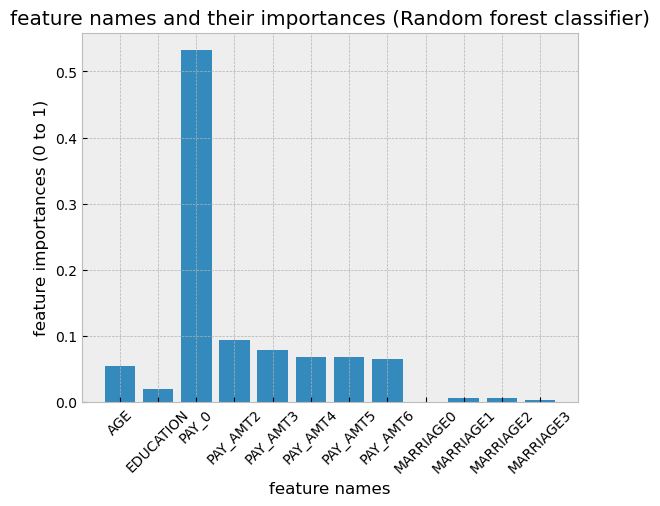

In [33]:
plt.style.use("bmh")
plt.bar(final_feat_imp_df.index, final_feat_imp_df["feature_imp"])
plt.xticks(rotation = 45)
plt.title("feature names and their importances (Random forest classifier)")
plt.xlabel("feature names")
plt.ylabel("feature importances (0 to 1)")
plt.show

Based on the above analysis, it seems that the payment status in the first month has the highest importance out of all the selected features for the fact whether the client defaults or not with a worse payment status resulting in a higher chance of being default. This makes sense as the pay status would directly related to how much money the client has and the chance of them being default.

The next few factors include the amount paid for the following months in decreasing importance with higher amount paid resulting in higher chance of default. The same trend follows for age. This would make as by making larger payments, you reduce the outstanding balance on your credit card. This lowers your credit utilization ratio, which is the percentage of your available credit that you're currently using. A lower credit utilization ratio is generally considered favorable and can positively impact your credit score. A higher credit score indicates that you manage credit responsibly, reducing the chances of default.

Education and marriage does not seem to have a high correlation with the client being default or not. 


<br><br>

## Test results

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import shap

In [38]:
y_pred = final_est.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

explainer = shap.TreeExplainer(final_est.named_steps["randomforestclassifier"])
shap_values = explainer.shap_values(X_test)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:])

0.823
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      7052
           1       0.69      0.33      0.45      1948

    accuracy                           0.82      9000
   macro avg       0.76      0.64      0.67      9000
weighted avg       0.81      0.82      0.80      9000



- The test scores seem to be similar (higher even), which suggests there was very little optimization bias with the hyperparameter optimization. Because of this, combined with the large training/test size, we trust these results. 
- The SHAP plot shows the result for X_test's 0 index where the base value of it is 0.5 with the majority of the value being decided by the lower education level and the marriage status 2 with both of them resulting in a magnitude of 2. The marriage status 2 pushes it towards a higher base value but the lower education level has much more impact and pushes it towards a lower base value. There are other features too however, they have a neglectful impact when in comparison to ```EDUCATION``` and ```MARRIAGE```



<br><br>

## Summary of results

In [39]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

eval_ = {}

eval_["accuracy"] = accuracy_score(y_test, final_est.predict(X_test))
eval_["error"] = 1 - eval_["accuracy"]
eval_["precision"] = precision_score(y_test, final_est.predict(X_test))
eval_["recall"] = recall_score(y_test, final_est.predict(X_test))
eval_["f1 score"] = f1_score(y_test, final_est.predict(X_test))

eval_df = pd.DataFrame.from_dict(eval_, orient = "index", columns = ["calculation"])
eval_df

,calculation
accuracy,0.823000
error,0.177000
precision,0.691066
recall,0.329569
f1 score,0.446298


In [40]:
cm = confusion_matrix(y_test, final_est.predict(X_test))
TN, FP, FN, TP = cm.ravel()
TN, FP, FN, TP

(6765, 287, 1306, 642)

2. As stated above, we are going to be using f1 score to evaluate our model. It seems to have yielded in a lower f1 score than expected with only resulting in a f1 score of 0.445603. This seems to be due to the low recall score as the model seems to not be identifying only 0.329055 of the clients who default. This is most likely due to the imbalance in the classes with the majority being clients who don't default. The precision score also seems to be low as only 0.689989 of the model's classifcation of clients who default seems to be correct. This could also be attributed to the class imbalance as the model might not be tuned to deal with the lower proportions of clients who default. The model does seem to be performing better than what f1 score suggest as it has an accuracy of 0.822778. Looking at the classification matrix allows us to understand that the model does have a bias towards negatives as it results in higher false negatives than false positives.

3. This model could be improved by optimising for class weights and accounting for the bias towards the negatives. This model could also be improved by optimising the threshold to maximise both precision and recall where the current model has a higher precision than recall but that depends on the context of the problem (if the model should be more sensitive to clients who default or not). Due to computation and time limitation, certain models were not used or explored such as SVC or gradient boosted trees, these models should be explored and have hyperparameter optimisation given enough time. These models would most likely result in a better model which would yield better evaluation metrics but would require a lot more fitting and predicting time. 

4. As stated in the part 2 of this answer, the model seems to have high accuracy but low f1 score which is most likely due to not being optimised for the difference in class weights.

<br><br>

## Key takeaways

1. Different problems need different models. There's no one-size-fits-all in machine learning. 
2. Tuning model parameters is crucial. It can make a good model great, but it's easy to overfit if we're not careful. 
3. Explaining results is as important as getting them. Tools like SHAP can help break down which features matter and why. 
4. Always validate your model on a test set and obey the golden rule. It's the best way to know how it'll perform on new data.

We learned a lot from this project. Payment status and amounts matter. Personal details like age, education and marriage - not so much. Also learned that we sometimes have to make tradeoffs. For instance, while the SVC model was the best performer, it was too slow. So we went with RandomForestClassifier, a slightly less accurate but much faster option.